# Initialization

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# for image data handling
import os
from os.path import join, isfile, dirname
from PIL import Image

# Data Handling

### Uncompress compressed files

In [2]:
%%capture
!unzip -n ../data/images.zip -d ../data

### Custom functions

In [3]:
def genFromImage(imageDir, size=(8, 8)):
    dir = dirname(imageDir)
    dataFile = join(dir, "p4_data") + str(size) + ".npy"
    if isfile(dataFile):
        with open(dataFile, 'rb') as f:
            return np.load(f)
    
    labels = os.listdir(imageDir)
    image_data = [[] for _ in labels]
    for label in labels:
        dir = join(imageDir, label)
        files = os.listdir(dir)
        image_data[int(label)] = np.array([np.array(
            Image.open(join(dir, file)).convert("L").resize(size), dtype='uint8'
        ) for file in files])
        
    image_data = np.array(image_data)
    with open(dataFile, 'wb') as f:
        np.save(f, image_data)
    return image_data

# returns X, Y, X_test, Y_test and classStats
def trainTestSplit(data, train_ratio, func):
    n = len(data)
    m = int(np.floor(data.shape[1] * train_ratio))
    classStats = {}
    x_train, y_train, x_test, y_test = [[[] for _ in range(n)] for _ in range(4)]
    for label in range(n):
        x_train[label], y_train[label], classStats[label] = func(label, data[label][:m], True)
        x_test[label], y_test[label] = func(label, data[label][m:])
    
    X, Y, X_test, Y_test = [x.reshape(-1, x.shape[-1]) for x in [np.array(x) for x in [x_train, y_train, x_test, y_test]]]
    return X, np.array(Y.flatten(), dtype=int), X_test, np.array(Y_test.flatten(), dtype=int), classStats

def imgToFeatures(label, data, stats=False):
    X = np.array([x.flatten() for x in data]) / 255
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

def stats(label, data, stats=False):
    X = data
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

### Data extraction

In [4]:
dataFolder = "../data"
imageDir = join(dataFolder, "images")

# p1 = { "testDir": dataFolder + "/p1_test.csv", "trainDir": dataFolder + "/p1_train.csv" } # regression
# p2 = { "testDir": dataFolder + "/p2_test.csv", "trainDir": dataFolder + "/p2_train.csv" } # regression
p3 = { "testDir": dataFolder + "/p3_test.csv", "trainDir": dataFolder + "/p3_train.csv" } # classification
p4 = {}                                                                                   # classification
p5 = {}                                                                                   # classification

# p1["test"] = np.genfromtxt(p1["testDir"], delimiter=',')
# p1["train"] = np.genfromtxt(p1["trainDir"], delimiter=',')
# p2["test"] = np.genfromtxt(p2["testDir"], delimiter=',')
# p2["train"] = np.genfromtxt(p2["trainDir"], delimiter=',')
p3["test"] = np.genfromtxt(p3["testDir"], delimiter=',')
p3["train"] = np.genfromtxt(p3["trainDir"], delimiter=',')
p4["data"] = genFromImage(imageDir)
p5["data"] = np.genfromtxt(dataFolder + "/PCA_MNIST.csv", delimiter=',')[1:]

print("--------------------------- Data Shapes ------------------------------")
# print("    (Regression) p1[train]:      ", p1["train"].shape, ", p1[test]: ", p1["test"].shape)
# print("    (Regression) p2[train]:      ", p2["train"].shape, ", p2[test]: ", p2["test"].shape)
print("(Classification) p3[train]:     ", p3["train"].shape, ", p3[test]: ", p3["test"].shape)
print("(Classification)  p4[data]:", p4["data"].shape)
print("(Classification)  p5[data]:     ", p5["data"].shape)

--------------------------- Data Shapes ------------------------------
(Classification) p3[train]:      (60000, 11) , p3[test]:  (15000, 11)
(Classification)  p4[data]: (10, 6000, 8, 8)
(Classification)  p5[data]:      (60000, 11)


In [5]:
classStats = {}
for row in p3["train"]:
    label = int(row[-1]) - 1
    if label in classStats:
        classStats[label].append(row[:-1])
    else:
        classStats[label] = [row[:-1]]

# classStats = [np.array(data) for data in classStats]
for i in range(len(classStats)):
    data = np.array(classStats[i])
    classStats[i] = { "mean": np.mean(data, axis=0), "cov": np.cov(data.T), "prior": data.shape[0], "data": data }
    
def splitData(data):
    # X = np.array([normalize(col) for col in data.T[:-1]]).T
    X = data.T[:-1].T
    Y = data.T[-1].T.astype("int") - 1
    return X, Y

p3["classStats"] = classStats
p3["X"], p3["Y"] = splitData(p3["train"])
p3["X_test"], p3["Y_test"] = splitData(p3["test"])

p3["X"].shape, p3["Y"].shape, p3["X_test"].shape, p3["Y_test"].shape

((60000, 10), (60000,), (15000, 10), (15000,))

In [6]:
p4["X"], p4["Y"], p4["X_test"], p4["Y_test"], p4["classStats"] = trainTestSplit(p4["data"], 0.7, imgToFeatures)

p4["X"].shape, p4["Y"].shape, p4["X_test"].shape, p4["Y_test"].shape

((42000, 64), (42000,), (18000, 64), (18000,))

In [7]:
classWiseData = [[] for _ in range(10)]
for row in p5["data"]:
    label = int(row[0])
    classWiseData[label].append(row[1:])
    
p5["X"], p5["Y"], p5["X_test"], p5["Y_test"], p5["classStats"] = trainTestSplit(np.array(classWiseData), 0.5, stats)
p5["X"].shape, p5["Y"].shape, p5["X_test"].shape, p5["Y_test"].shape

((30000, 10), (30000,), (30000, 10), (30000,))

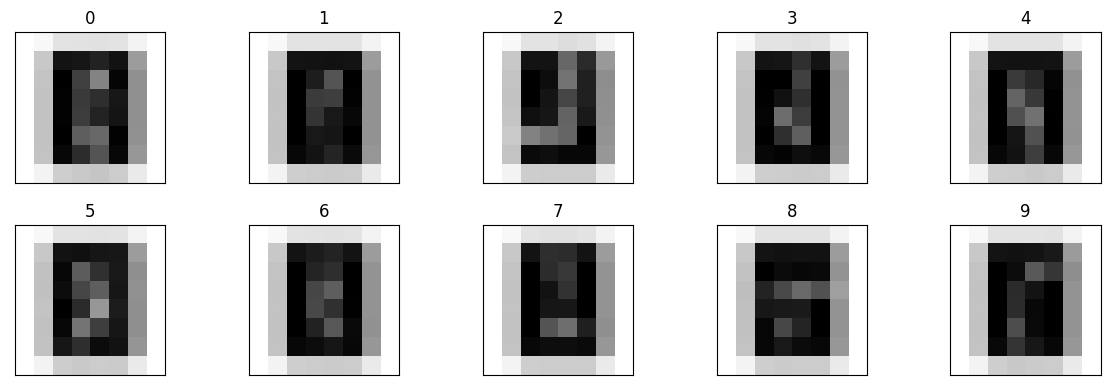

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(p4["data"].shape[0]):
    ax[i // 5][i % 5].imshow(p4["data"][i][0].astype(np.uint8), cmap='gray')
    ax[i // 5][i % 5].set_title(str(i))
    ax[i // 5][i % 5].get_xaxis().set_visible(False)
    ax[i // 5][i % 5].get_yaxis().set_visible(False)

fig.tight_layout()

# Metrics

In [9]:
class metrics:
    def accuracy(predicted, actual):
        m = actual.size
        correctCount = sum([1 if int(predicted[i]) == int(actual[i]) else 0 for i in range(m)])
        return correctCount / m
    
    def confusionMatrix(predicted, actual, n = 5):
        cnf = np.zeros((n, n), dtype='uint')
        for i in range(actual.size):
            cnf[int(actual[i])][int(predicted[i])] += 1
        return cnf
    
    def f1Score(cnf):
        sum_predict = np.sum(cnf, axis=0)
        sum_actual  = np.sum(cnf, axis=1)
        f1 = np.zeros(cnf.shape[1])
        for i in range(f1.size):
            TP = cnf[i][i]
            FP, FN = sum_predict[i] - TP, sum_actual[i] - TP
            p, r = TP/(TP + FP + 1e-8), TP/(TP + FN + 1e-8)
            f1[i] = 2 * p * r / (p + r + 1e-8)
        return f1    

    def printCnf(cnf_train, cnf_test):
        print("Confusion Matrix:")
        print(cnf_test)
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].matshow(cnf_train.T, cmap='GnBu')
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Actual")
        ax[0].set_title("Confusion Matrix (train)")
        for (x, y), value in np.ndenumerate(cnf_train):
            ax[0].text(x, y, f"{value: .0f}", va="center", ha="center")
        
        ax[1].matshow(cnf_test.T, cmap='GnBu')
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("Actual")
        ax[1].set_title("Confusion Matrix (test)")
        for (x, y), value in np.ndenumerate(cnf_test):
            ax[1].text(x, y, f"{value: .0f}", va="center", ha="center")

    
    def print(pred, Y, pred_test, Y_test, visualize=True, result=False):
        n_labels = len(np.unique(Y))
                
        cnf_train = metrics.confusionMatrix(pred, Y, n_labels)
        cnf_test = metrics.confusionMatrix(pred_test, Y_test, n_labels)
        acc_train = metrics.accuracy(pred, Y)
        acc_test = metrics.accuracy(pred_test, Y_test)
        f1_train = metrics.f1Score(cnf_train)
        f1_test = metrics.f1Score(cnf_test)
        
        if visualize:
            print("------------------ Train ---------------------")
            print("Classification Accuracy : ", acc_train * 100, "%")
            print("Average F1 Score                : ", np.average(f1_train))
            print("------------------ Test ----------------------")
            print("Classification Accuracy : ", acc_test * 100, "%")
            print("Average F1 Score                : ", np.average(f1_test))
            
            metrics.printCnf(cnf_train, cnf_test)
        
        if result:
            return [acc_train, f1_train, cnf_train], [acc_test, f1_test, cnf_test]

# Problem 1

Implement classification trees using Gini impurity and cross-entropy as impurity functions with different depths. 

For the MNIST problem, consider the PCA data

Data: `p3, p5`

## Implementation

### Impurity Funcions

In [10]:
def gini(data):
    n = data.shape[0]
    if n == 0:
        return 0
    p = np.bincount(data) / n
    return 1 - np.sum(p ** 2)

print("Gini (test): ", gini(p3["Y"]), gini(p3['Y'][p3["Y"] == 0]))

def entropy(data):
    n = data.shape[0]
    if n == 0:
        return 0
    p = np.bincount(data) / n
    return -np.sum(p * np.log2(p + 1e-8))

print("Entropy (test): ", entropy(p3["Y"]), entropy(p3['Y'][p3["Y"] == 0]))

Gini (test):  0.7999987455555555 0.0
Entropy (test):  2.3219234968181315 -1.442695024907551e-08


### CART algorithm

In [16]:
# restricting the number of thresholds to increase the speed of the algorithm
def recommendedThresholds(col, y):
    a = np.c_[col, y]
    a.sort(axis=0)
    b = []
    for i in range(1, a.shape[0]):
        if a[i][1] != a[i - 1][1]:
            b.append((a[i][0] + a[i - 1][0]) / 2)
    return b

def recommendedSplit(X, y, impurity, skip_features_idx=[]):
    best_impurity = 1e9
    best_split = None
    for i, col in enumerate(X.T):
        if i in skip_features_idx:
            continue
        ts = recommendedThresholds(col, y)
        for t in ts:
            left, right = y[col <= t], y[col > t]
            impurity_split = (impurity(left) * left.size + impurity(right) * right.size) / y.size
            if impurity_split < best_impurity:
                best_impurity = impurity_split
                best_split = (i, t)
    return best_split

recommendedSplit(p3["X"], p3["Y"], gini)

(5, 1.3925129339837405)

### Decision Tree

In [17]:
# inner nodes are [i, t, left, right]
# leaf node is a number (class label)
# returns a tree in pre-order traversal format
def buildTree(X, y, impurity, max_depth, depth=0, skip_features_idx=[]):
    if depth == max_depth:
        return [np.argmax(np.bincount(y))]
    if np.unique(y).size == 1:
        return [y[0]]
    
    split = recommendedSplit(X, y, impurity, skip_features_idx)

    if split is None:
        return [np.argmax(np.bincount(y))]
    
    i, t = split
    left, right = y[X[:, i] <= t], y[X[:, i] > t]
    leftX, rightX = X[X[:, i] <= t], X[X[:, i] > t]

    if left.size == 0 or right.size == 0:
        return [np.argmax(np.bincount(y))]
    
    return [split, buildTree(leftX, left, impurity, max_depth, depth + 1), buildTree(rightX, right, impurity, max_depth, depth + 1)]

def printTree(tree, depth=0):
    if len(tree) == 1:
        print(" " * depth, "Leaf: ", tree[0])
    else:
        print(" " * depth, f"Split: {tree[0][0]:.2f} <=  {tree[0][1]:.2f}")
        printTree(tree[1], depth + 1)
        printTree(tree[2], depth + 1)

def predict(X, tree):
    if len(tree) == 1:
        return tree[0]
    i, t = tree[0]
    return predict(X, tree[1]) if X[i] <= t else predict(X, tree[2])
    
def predictAll(X, tree):
    return np.array([predict(x, tree) for x in X])


## Experiment on P3 Data

### Using Gini as impurity measure

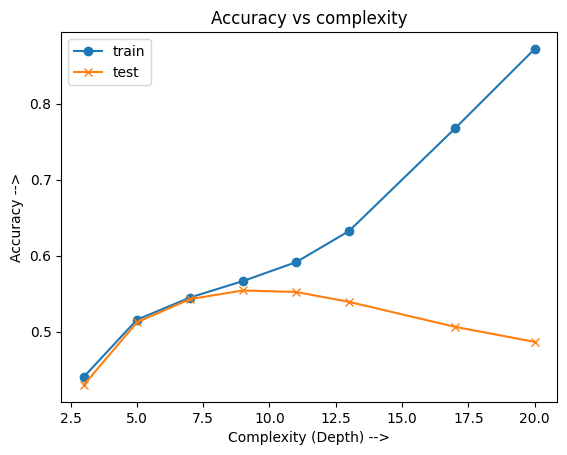

In [59]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p3["X"], p3["Y"], gini, depth)
    results.append(metrics.print(predictAll(p3["X"], tree), p3["Y"], predictAll(p3["X_test"], tree), p3["Y_test"], visualize=False, result=True))

bestResult_p3_gini = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 55.42%, F1 Score: 0.56
Confusion Matrix:
[[1551  589  251  287  293]
 [ 413 1808  275  262  223]
 [ 339  506 1804  198  193]
 [ 354  574  262 1608  177]
 [ 380  609  230  272 1542]]


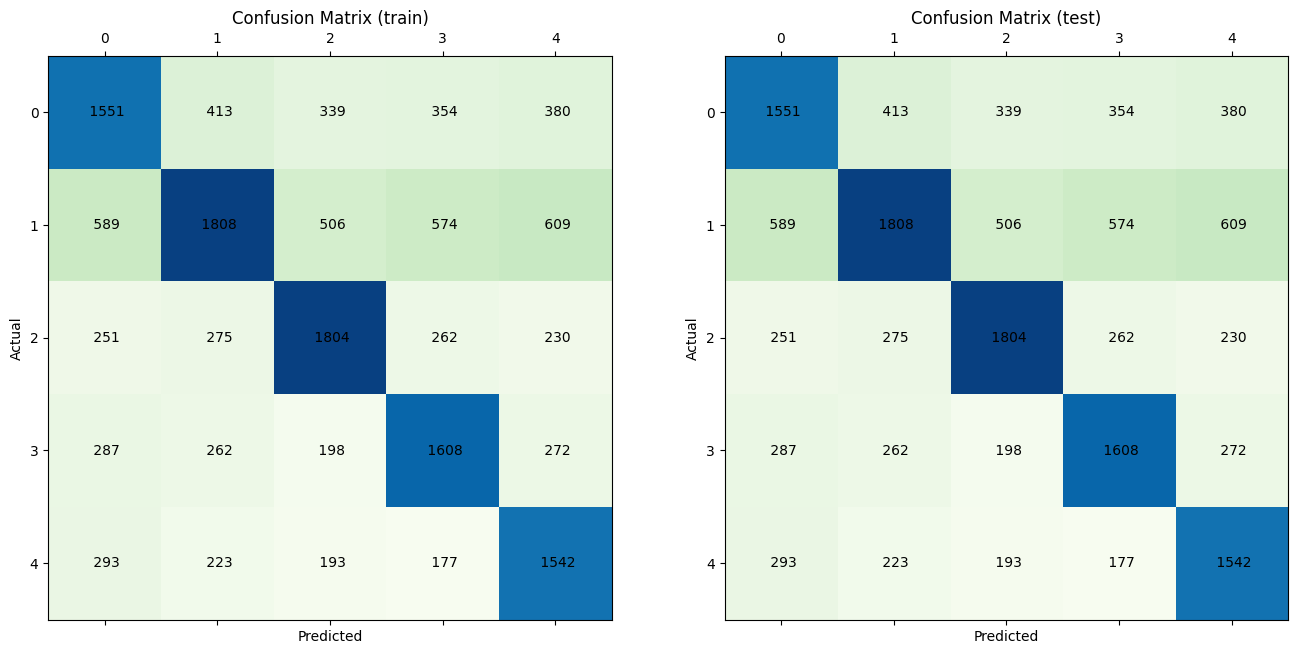

In [83]:
print(f"Test Accuracy: {bestResult_p3_gini[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p3_gini[1][1]):.2f}")
metrics.printCnf(bestResult_p3_gini[1][2], bestResult_p3_gini[1][2])

### Using Cross-Entropy as impurity measure

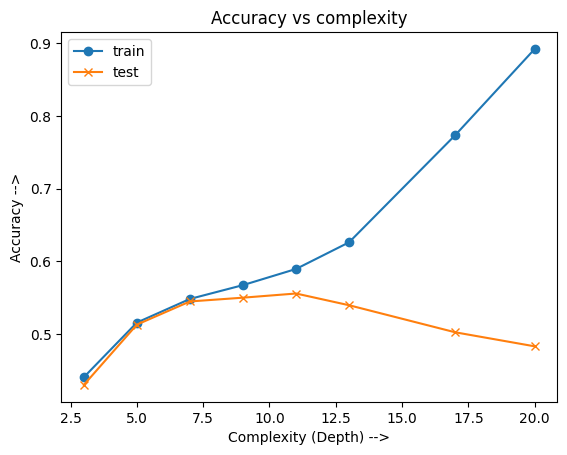

In [61]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p3["X"], p3["Y"], entropy, depth)
    results.append(metrics.print(predictAll(p3["X"], tree), p3["Y"], predictAll(p3["X_test"], tree), p3["Y_test"], visualize=False, result=True))

bestResult_p3_entropy = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 55.57%, F1 Score: 0.56
Confusion Matrix:
[[1599  371  240  330  431]
 [ 473 1604  259  265  380]
 [ 377  327 1744  221  371]
 [ 422  350  236 1655  312]
 [ 431  348  202  319 1733]]


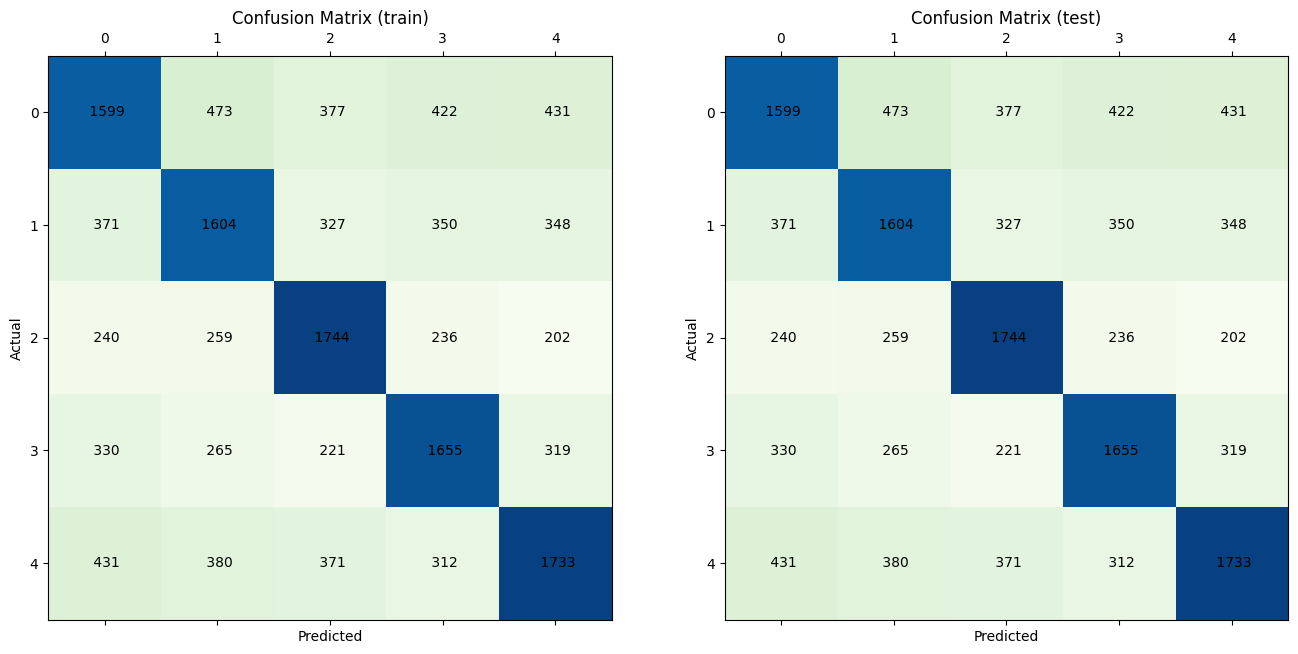

In [82]:
print(f"Test Accuracy: {bestResult_p3_entropy[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p3_entropy[1][1]):.2f}")
metrics.printCnf(bestResult_p3_entropy[1][2], bestResult_p3_entropy[1][2])

## Experiment on P5 Data (MNIST PCA)

### Using Gini as impurity measure

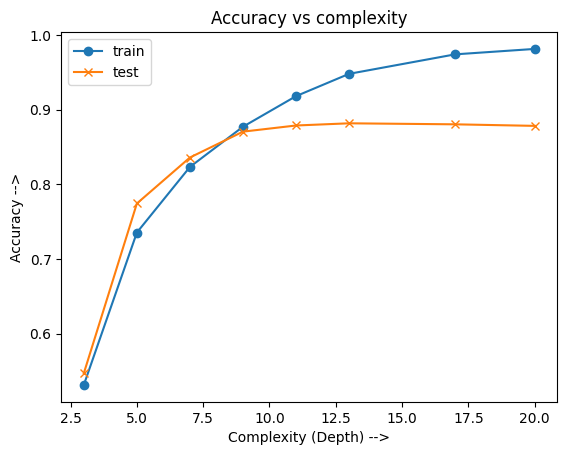

In [43]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p5["X"], p5["Y"], gini, depth)
    results.append(metrics.print(predictAll(p5["X"], tree), p5["Y"], predictAll(p5["X_test"], tree), p5["Y_test"], visualize=False, result=True))

bestResult_p5_gini = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 88.18%, F1 Score: 0.88
Confusion Matrix:
[[2608  219   23   21    3    6    5   19   68   28]
 [ 197 2648   10   23   34    6    4   25   26   27]
 [   8    6 2858   14    0   56    4    6    9   39]
 [  37   44   62 2633   26   60   44   52   29   13]
 [   2    1    1   50 2715  132   12   28    7   52]
 [   6   11   25   42  148 2676    5   11   68    8]
 [   4    0   10   41    9    8 2623  290    3   12]
 [   4    4   75  152   12    9  411 2314    1   18]
 [  94    9    6    4   20   14    4    5 2808   36]
 [  64   51   24   22   90   20   32   69   57 2571]]


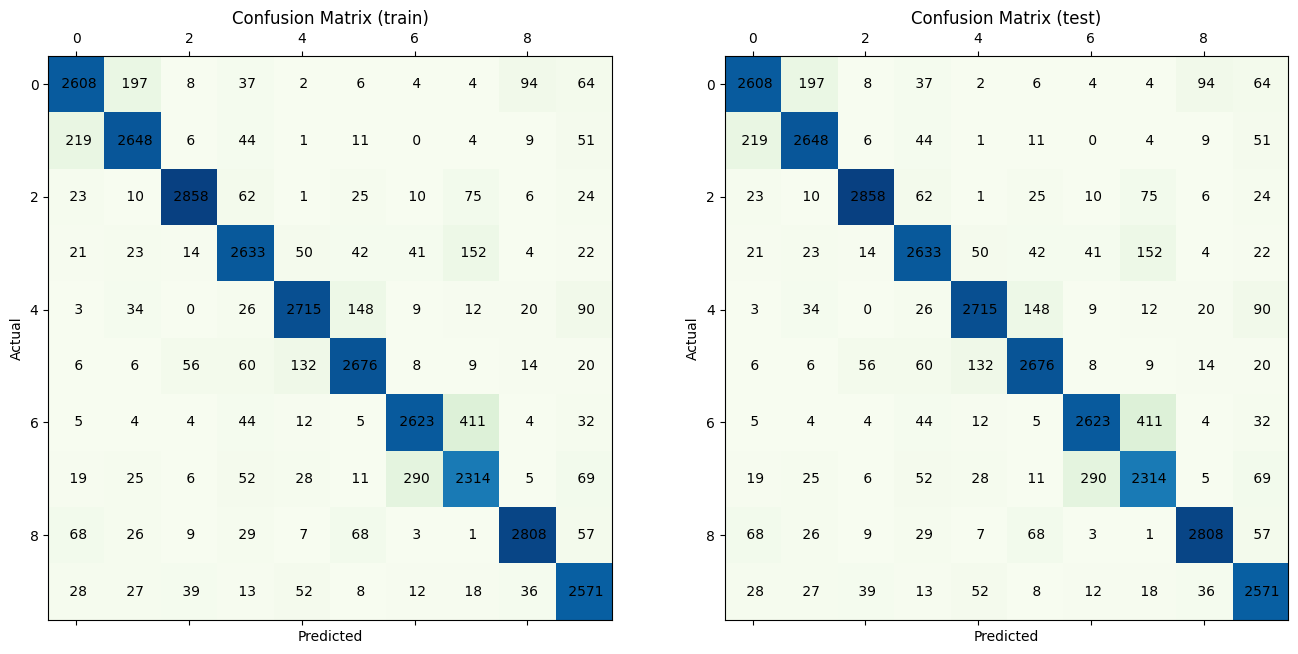

In [44]:
print(f"Test Accuracy: {bestResult_p5_gini[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p5_gini[1][1]):.2f}")
metrics.printCnf(bestResult_p5_gini[1][2], bestResult_p5_gini[1][2])

### Using Entropy as impurity measure

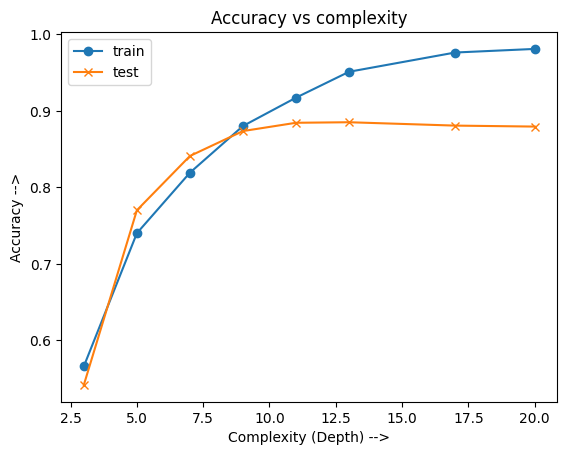

In [76]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p5["X"], p5["Y"], entropy, depth)
    results.append(metrics.print(predictAll(p5["X"], tree), p5["Y"], predictAll(p5["X_test"], tree), p5["Y_test"], visualize=False, result=True))

bestResult_p5_entropy = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 88.52%, F1 Score: 0.89
Confusion Matrix:
[[2612  218   13   34    6    2    3   12   83   17]
 [ 198 2641   15   34   16    4    8   13   44   27]
 [  12    9 2825   18    3   71    5    9   12   36]
 [  26   24   75 2644   27   49   36   71   32   16]
 [   2    2    6   43 2716  119   12   41   21   38]
 [   6   21   60   47  124 2628    8   19   63   24]
 [   3    0   14   40    3   16 2595  305    3   21]
 [   5    0   20  128   19    4  339 2466    0   19]
 [  72   15   10    4   22    8    2    2 2818   47]
 [  52   35   20   15   51   30   29   71   87 2610]]


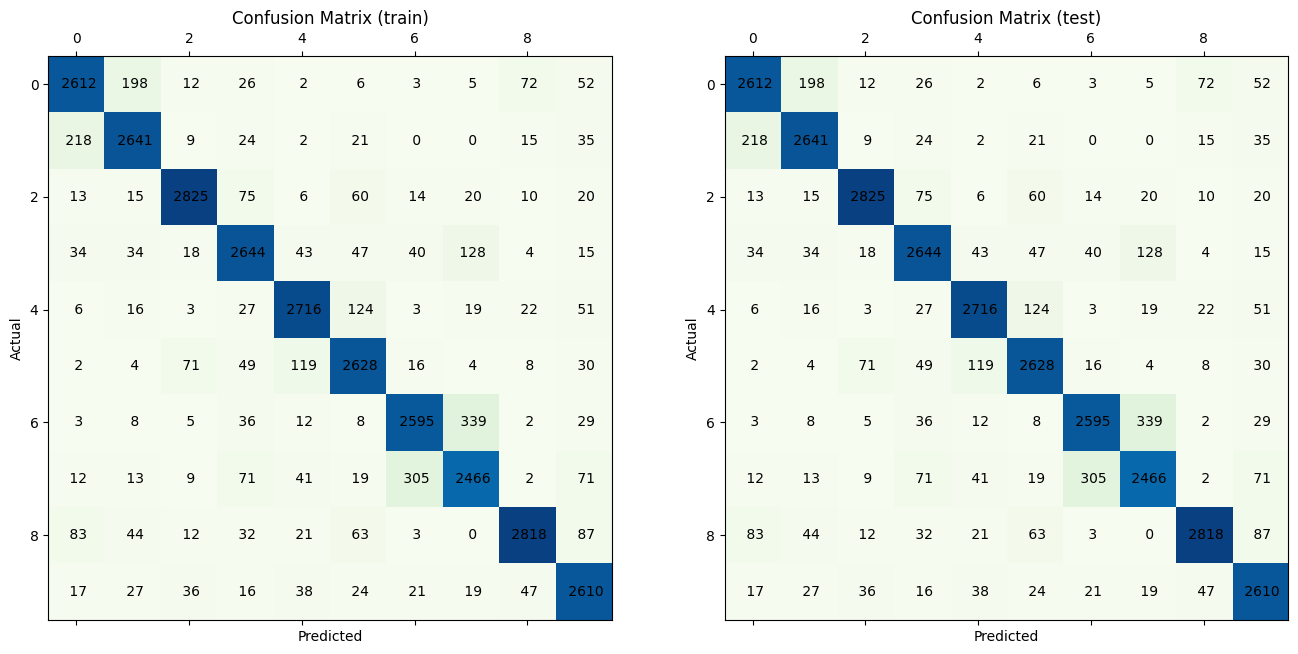

In [79]:
print(f"Test Accuracy: {bestResult_p5_entropy[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p5_entropy[1][1]):.2f}")
metrics.printCnf(bestResult_p5_entropy[1][2], bestResult_p5_entropy[1][2])

# Problem 2

Implement Random forest Algorithm with varying numbers of trees and features and report your observations

Data: `p3, p4, p5`

## Implementation

In [19]:
def bootstrap(X, Y):
    n = len(X)
    idx = np.random.choice(n, n, replace=False)
    return X[idx], Y[idx]

def random_forest(X, Y, n_trees=10, depth=5, impurity=gini, n_features=None):
    trees = []
    for _ in range(n_trees):
        X_train, Y_train = bootstrap(X, Y)
        idx = [] if n_features is None else np.random.choice(X_train.shape[1], X_train.shape[1] - n_features, replace=False)
        trees.append(buildTree(X_train, Y_train, impurity, depth, skip_features_idx=idx))
    return trees

def predictForest(X, trees):
    predictions = np.array([predictAll(X, tree) for tree in trees])
    return np.array([np.bincount(prediction).argmax() for prediction in predictions.T])

def predictForestProb(X, trees):
    predictions = np.array([predictAll(X, tree) for tree in trees])
    return np.array([np.bincount(prediction) / len(prediction) for prediction in predictions.T])



## Experiment on P3 data

### Number of trees: 10, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  69.32166666666667 %
Average F1 Score                :  0.6934162693566458
------------------ Test ----------------------
Classification Accuracy :  52.24666666666666 %
Average F1 Score                :  0.5219811394591043
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


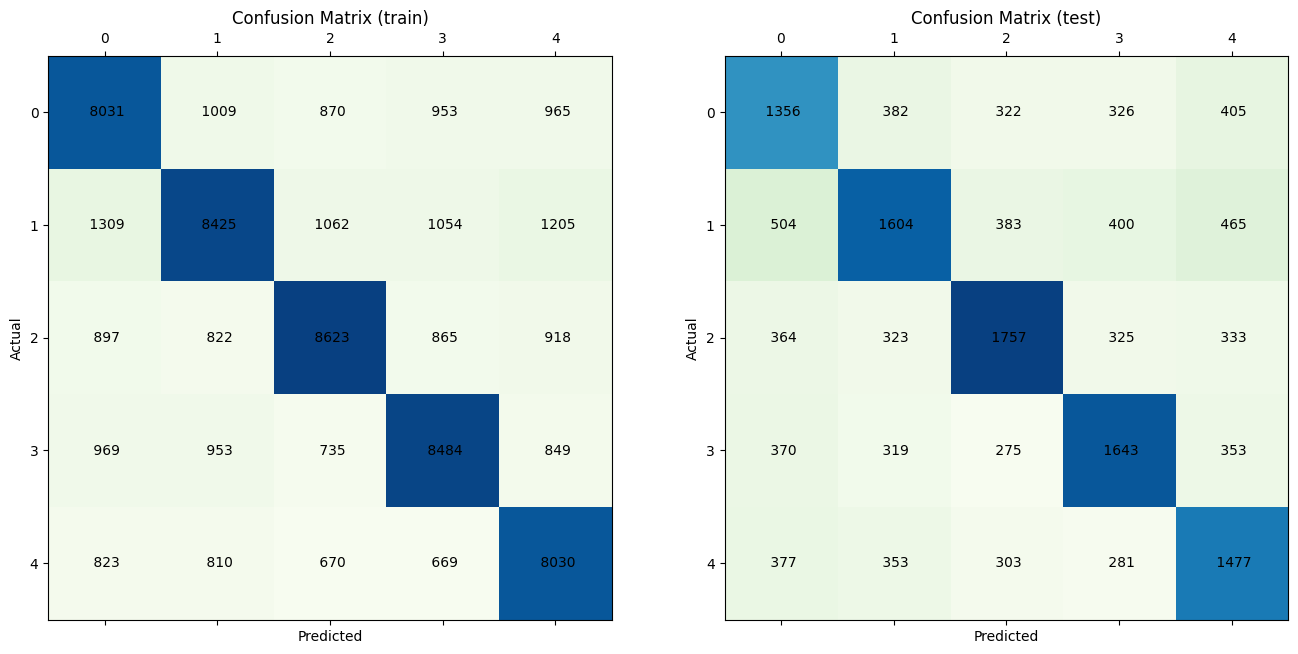

In [27]:
trees = random_forest(p3["X"], p3["Y"], n_trees=10, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 15, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  69.32166666666667 %
Average F1 Score                :  0.6934162693566458
------------------ Test ----------------------
Classification Accuracy :  52.24666666666666 %
Average F1 Score                :  0.5219811394591043
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


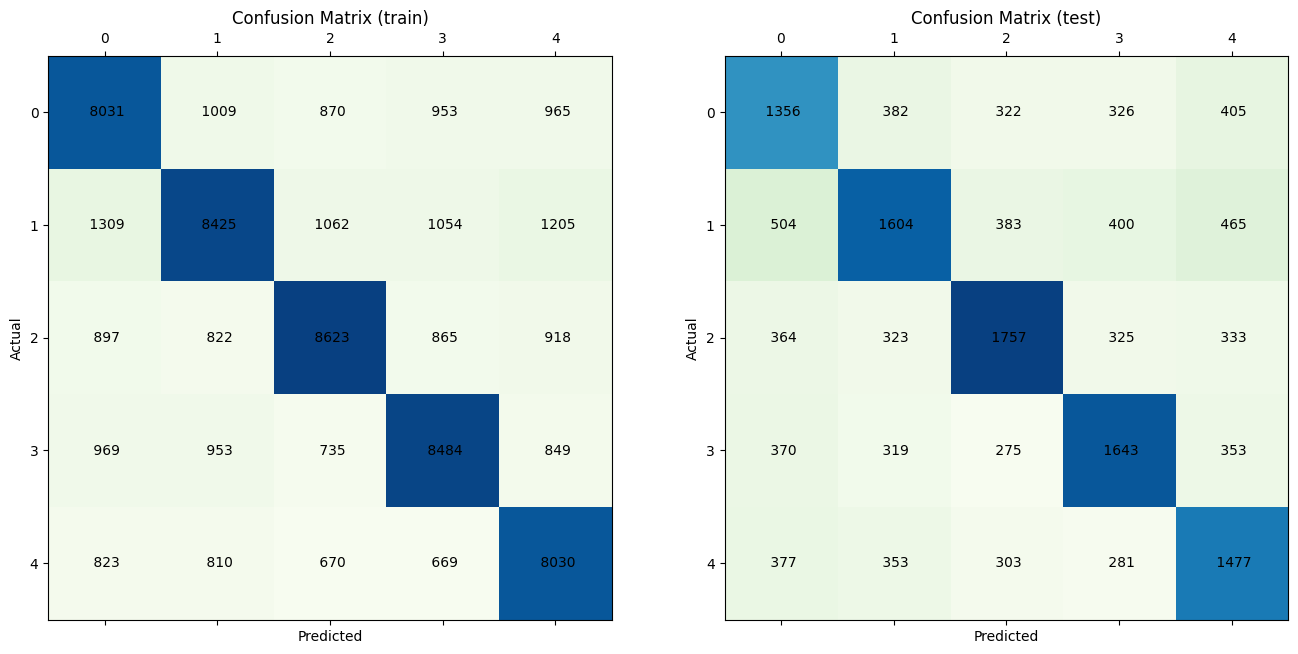

In [28]:
trees = random_forest(p3["X"], p3["Y"], n_trees=15, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  69.32166666666667 %
Average F1 Score                :  0.6934162693566458
------------------ Test ----------------------
Classification Accuracy :  52.24666666666666 %
Average F1 Score                :  0.5219811394591043
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


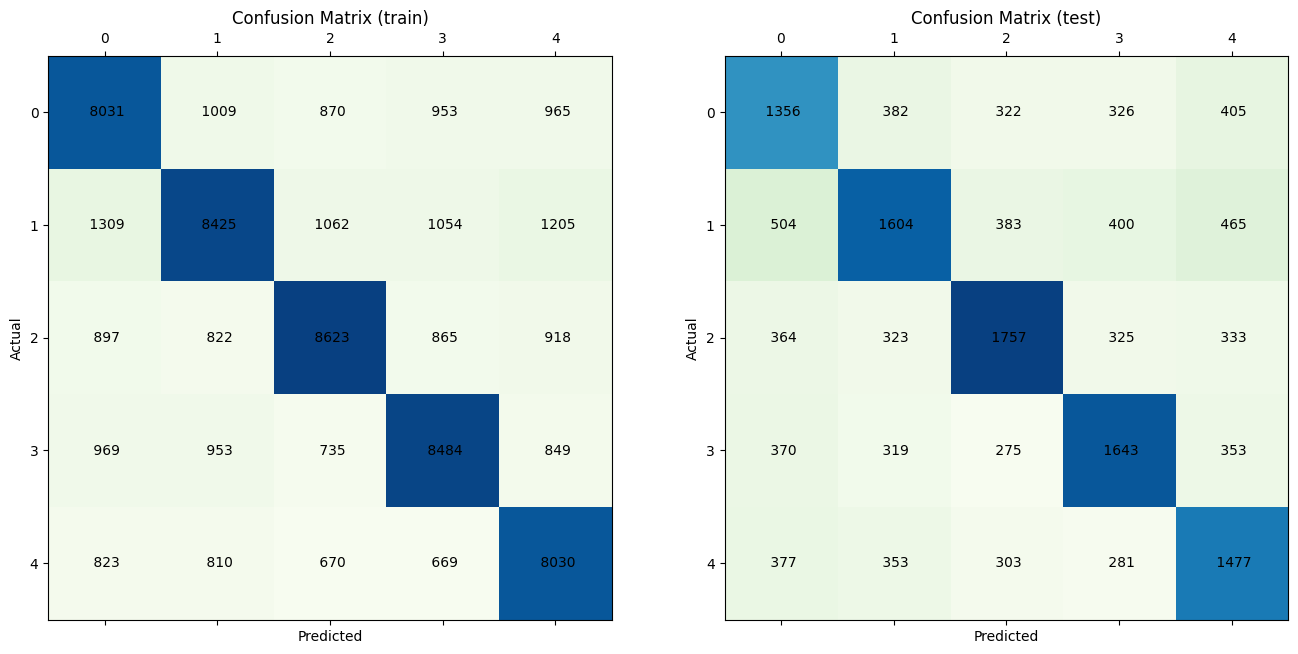

In [29]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 25, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  69.32166666666667 %
Average F1 Score                :  0.6934162693566458
------------------ Test ----------------------
Classification Accuracy :  52.24666666666666 %
Average F1 Score                :  0.5219811394591043
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


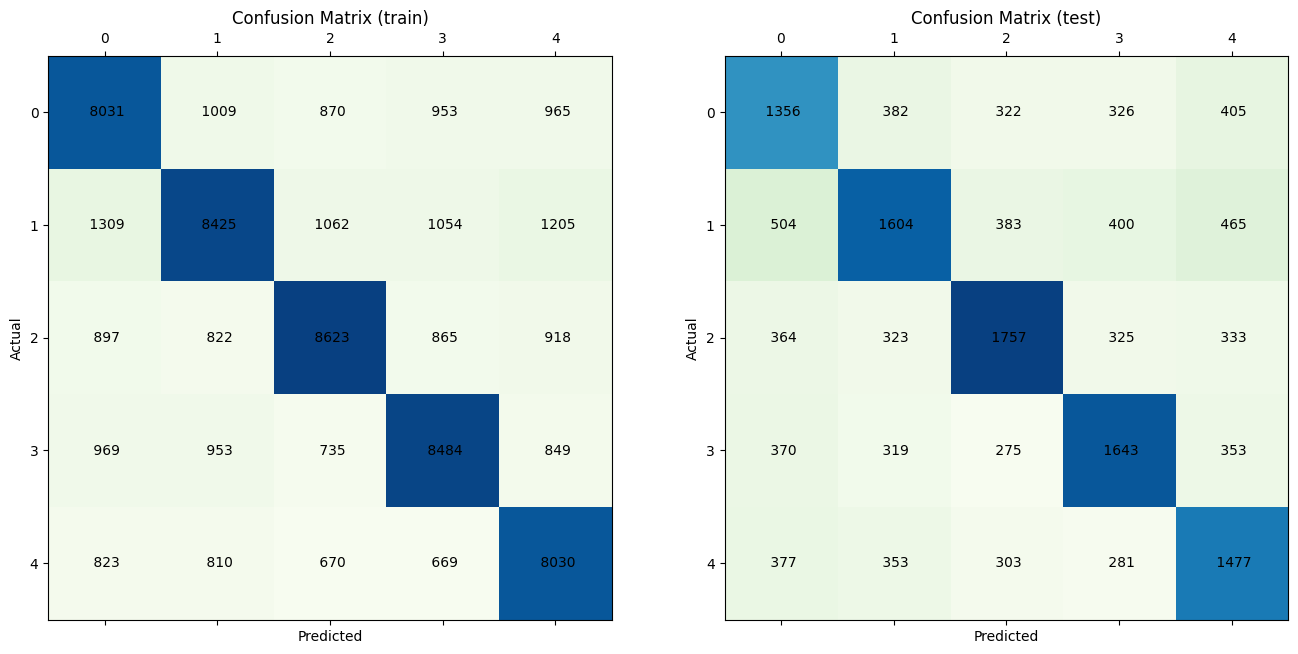

In [30]:
trees = random_forest(p3["X"], p3["Y"], n_trees=25, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 7

------------------ Train ---------------------
Classification Accuracy :  69.32166666666667 %
Average F1 Score                :  0.6934162693566458
------------------ Test ----------------------
Classification Accuracy :  52.24666666666666 %
Average F1 Score                :  0.5219811394591043
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


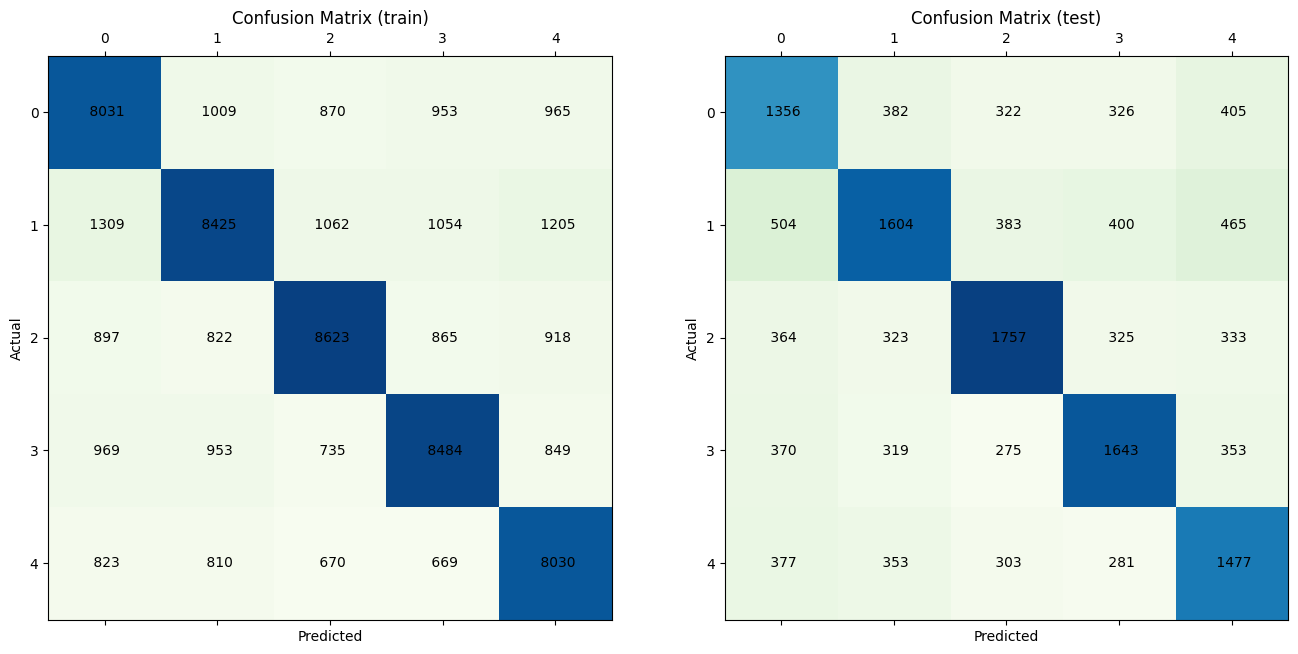

In [31]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini, n_features=7)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 5

------------------ Train ---------------------
Classification Accuracy :  71.94166666666668 %
Average F1 Score                :  0.7199312844819697
------------------ Test ----------------------
Classification Accuracy :  54.95333333333333 %
Average F1 Score                :  0.5497900940732403
Confusion Matrix:
[[1503  445  285  373  365]
 [ 410 1687  254  304  326]
 [ 337  376 1762  287  278]
 [ 349  374  251 1741  260]
 [ 441  424  266  352 1550]]


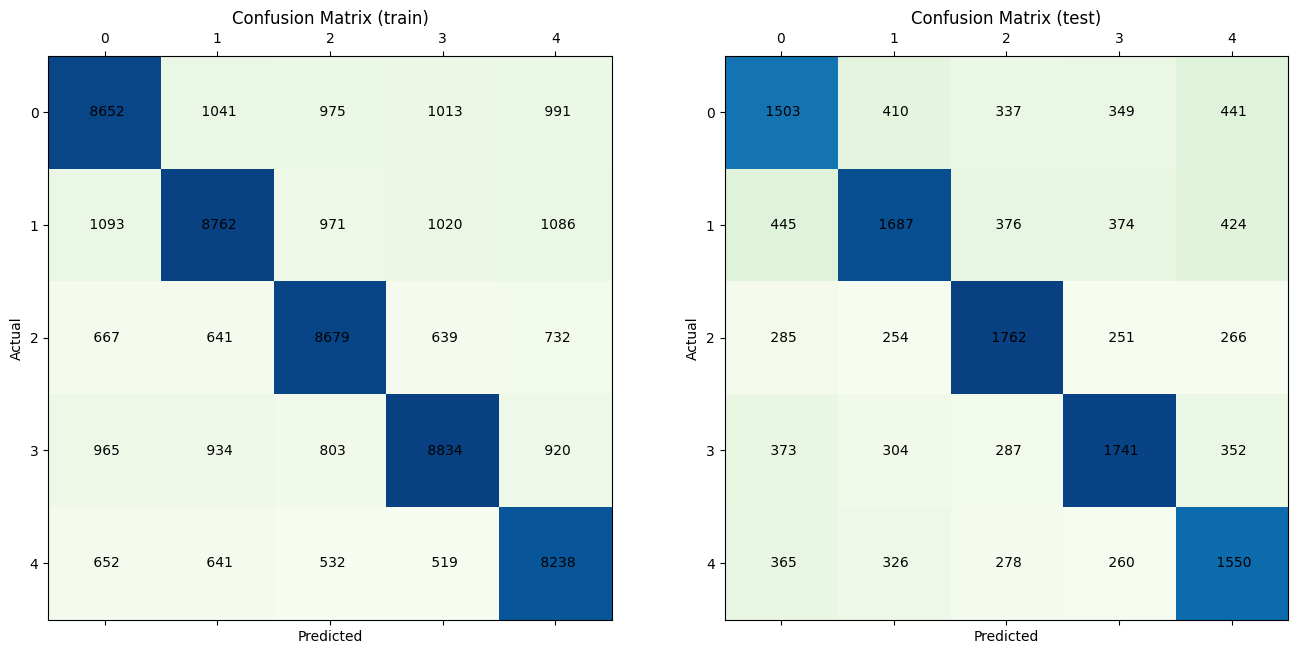

In [32]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini, n_features=5)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 3

------------------ Train ---------------------
Classification Accuracy :  72.48666666666666 %
Average F1 Score                :  0.7254852082376662
------------------ Test ----------------------
Classification Accuracy :  55.85333333333333 %
Average F1 Score                :  0.5590880366033082
Confusion Matrix:
[[1554  440  263  354  360]
 [ 421 1708  242  303  307]
 [ 341  361 1783  278  277]
 [ 376  374  239 1734  252]
 [ 425  414  252  343 1599]]


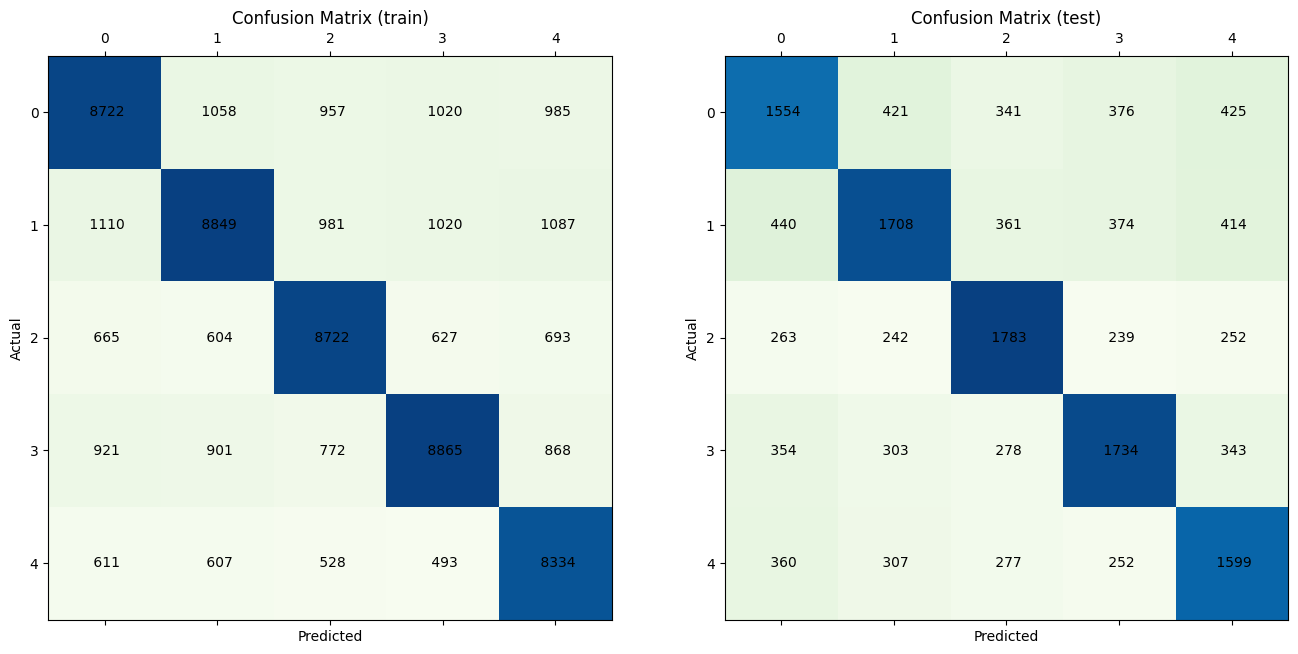

In [33]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini, n_features=3)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

## Experiment on P4 data

### Number of trees: 10, Number of features: 64

------------------ Train ---------------------
Classification Accuracy :  97.97142857142858 %
Average F1 Score                :  0.9797202307625696
------------------ Test ----------------------
Classification Accuracy :  91.37222222222222 %
Average F1 Score                :  0.9137350269555317
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


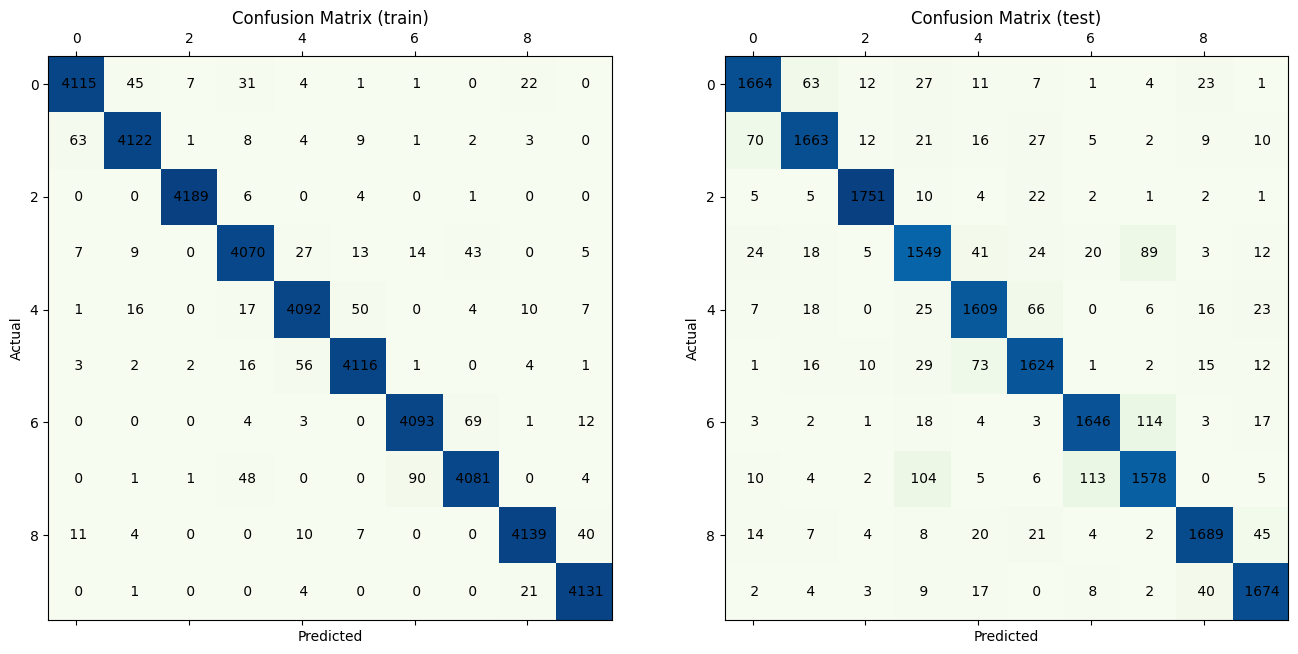

In [34]:
trees = random_forest(p4["X"], p4["Y"], n_trees=10, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 15, Number of features: 64

------------------ Train ---------------------
Classification Accuracy :  97.97142857142858 %
Average F1 Score                :  0.9797202307625696
------------------ Test ----------------------
Classification Accuracy :  91.37222222222222 %
Average F1 Score                :  0.9137350269555317
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


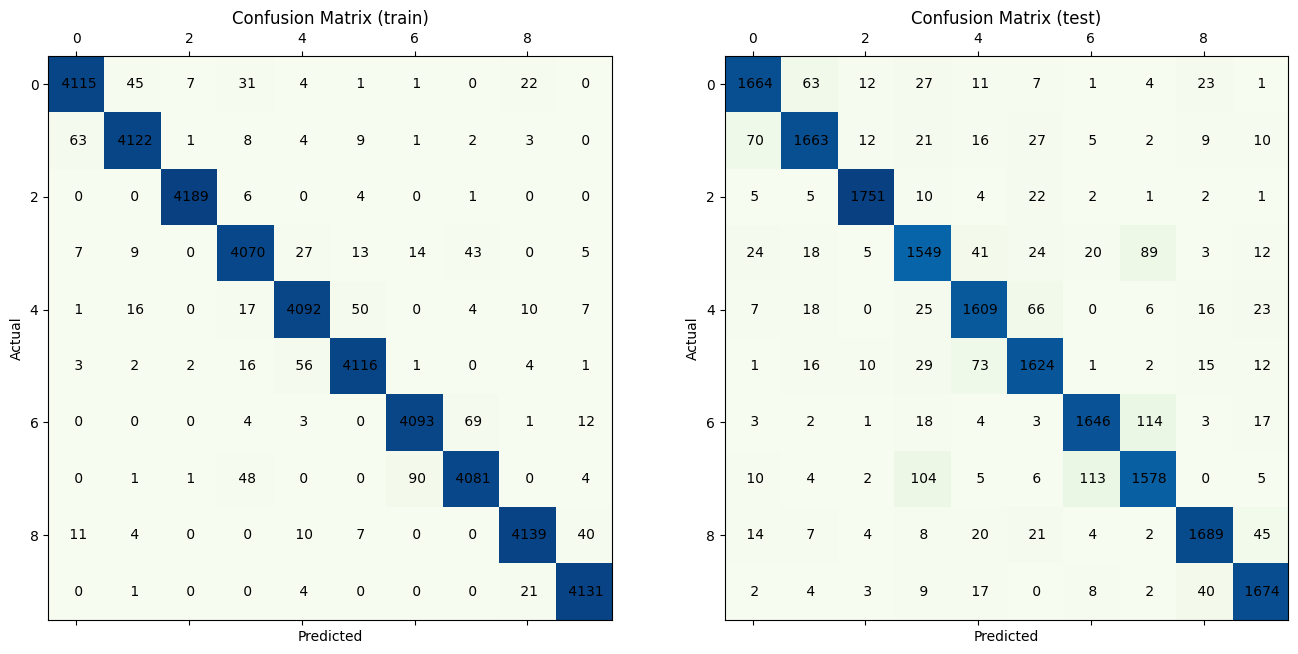

In [35]:
trees = random_forest(p4["X"], p4["Y"], n_trees=15, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 64

------------------ Train ---------------------
Classification Accuracy :  97.97142857142858 %
Average F1 Score                :  0.9797202307625696
------------------ Test ----------------------
Classification Accuracy :  91.37222222222222 %
Average F1 Score                :  0.9137350269555317
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


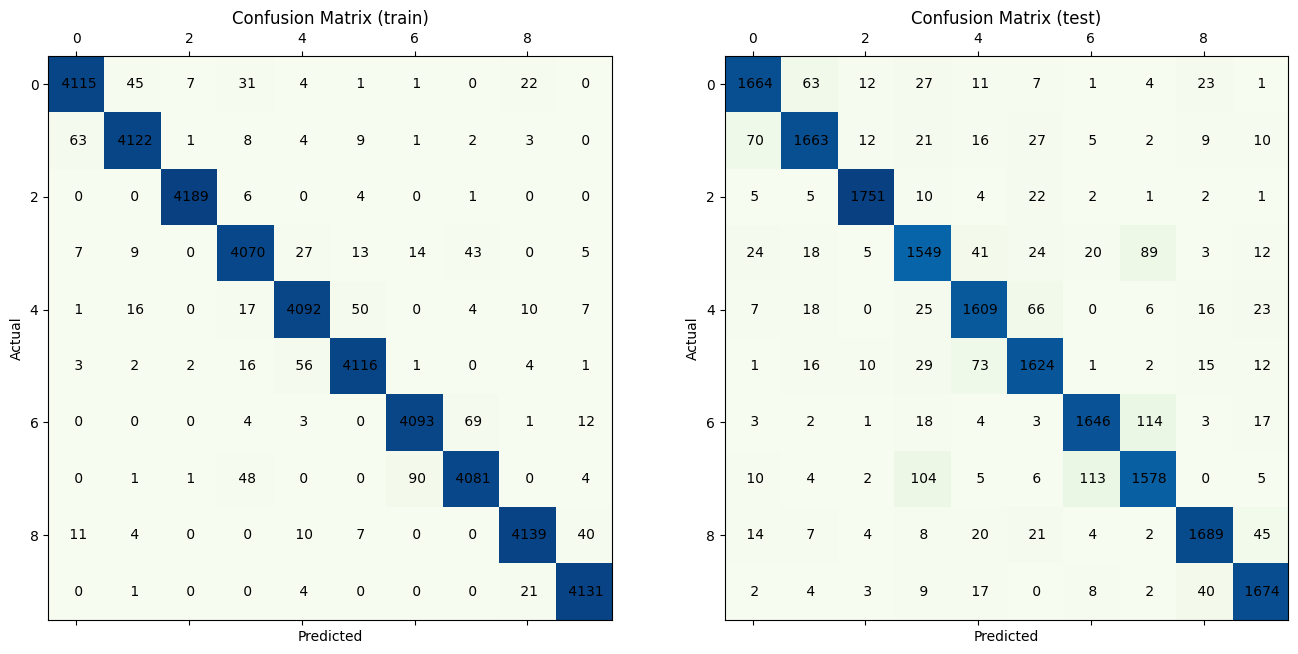

In [36]:
trees = random_forest(p4["X"], p4["Y"], n_trees=20, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 25, Number of features: 64

------------------ Train ---------------------
Classification Accuracy :  97.97142857142858 %
Average F1 Score                :  0.9797202307625696
------------------ Test ----------------------
Classification Accuracy :  91.37222222222222 %
Average F1 Score                :  0.9137350269555317
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


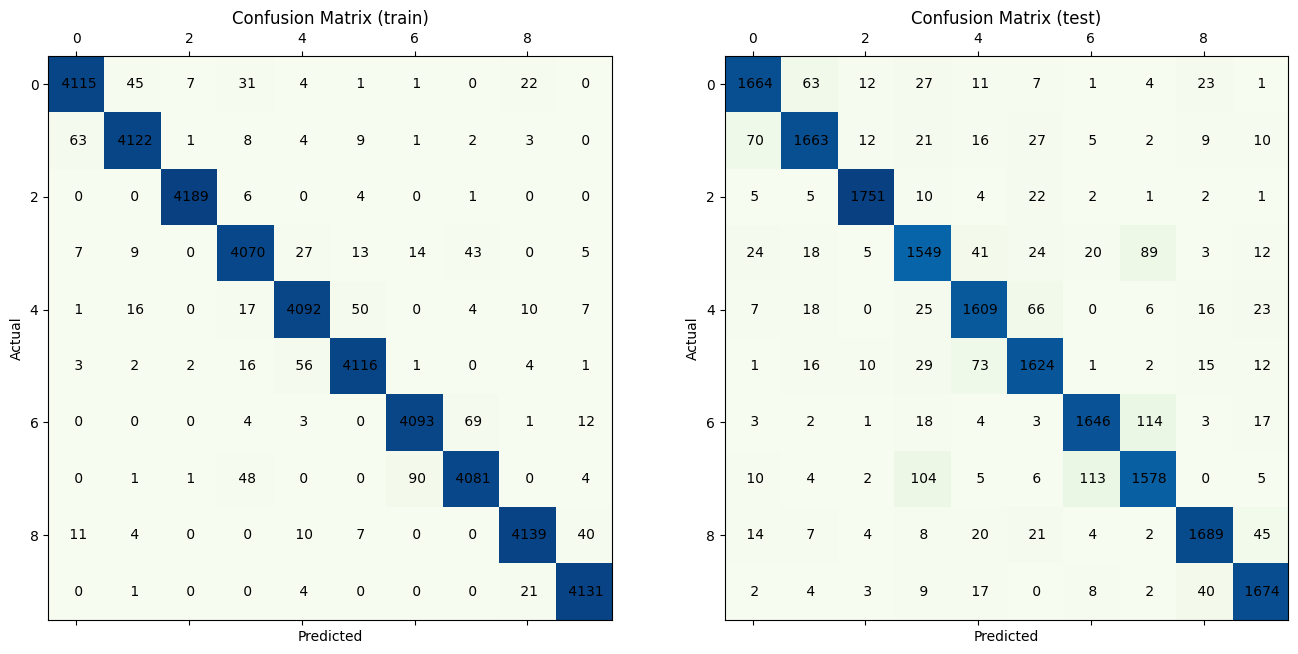

In [37]:
trees = random_forest(p4["X"], p4["Y"], n_trees=25, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 16

------------------ Train ---------------------
Classification Accuracy :  98.67142857142858 %
Average F1 Score                :  0.9867201462447366
------------------ Test ----------------------
Classification Accuracy :  94.78888888888889 %
Average F1 Score                :  0.9479242393371038
Confusion Matrix:
[[1710   54    4   16    3    2    1    3    4    3]
 [  26 1717    1   17   27    4    1    1    3    3]
 [   6    8 1771    5    1    8    0    0    1    0]
 [  25    7    6 1659   20   14    7   60    2    0]
 [   7    6    0   34 1690   34    2    1   12   14]
 [   2   12    8   18   46 1698    1    0   15    0]
 [   1    5    0   11    0    0 1728   52    0    3]
 [   3    4    1   61    8    1   69 1649    1    3]
 [  23    5    1    2    9    5    1    0 1729   25]
 [   3    1    0    8   11    3   20    6   37 1711]]


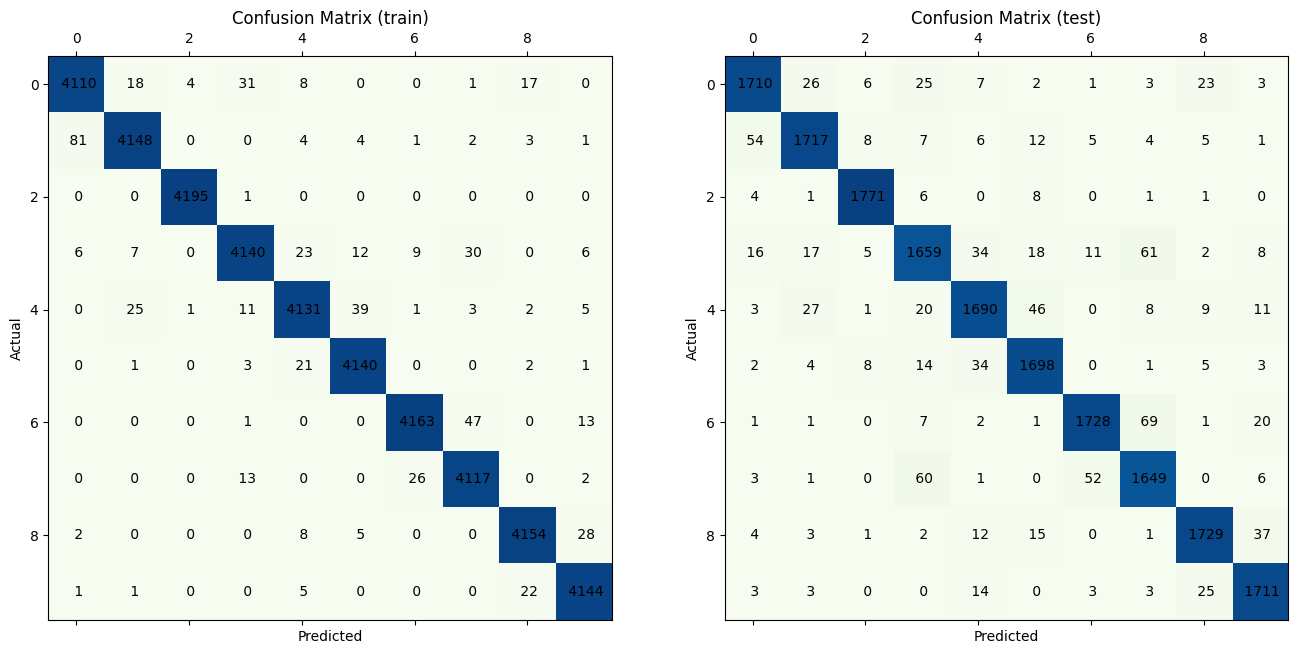

In [43]:
trees = random_forest(p4["X"], p4["Y"], n_trees=20, depth=15, impurity=gini, n_features=16)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 4

------------------ Train ---------------------
Classification Accuracy :  98.79761904761905 %
Average F1 Score                :  0.9879781043353881
------------------ Test ----------------------
Classification Accuracy :  95.76666666666667 %
Average F1 Score                :  0.9577160497193352
Confusion Matrix:
[[1719   52    1   13    4    1    2    2    4    2]
 [  25 1736    0   15   14    2    2    0    3    3]
 [   7    4 1780    4    4    1    0    0    0    0]
 [  29    6    1 1674   16   11    5   57    1    0]
 [   6    7    0   28 1714   29    1    0    7    8]
 [   1    6    2   13   41 1730    1    0    6    0]
 [   0    0    0   17    0    0 1722   59    0    2]
 [   2    5    0   43    7    0   63 1680    0    0]
 [  17    4    0    0    4    2    1    1 1750   21]
 [   1    1    0    4    7    2   15    6   31 1733]]


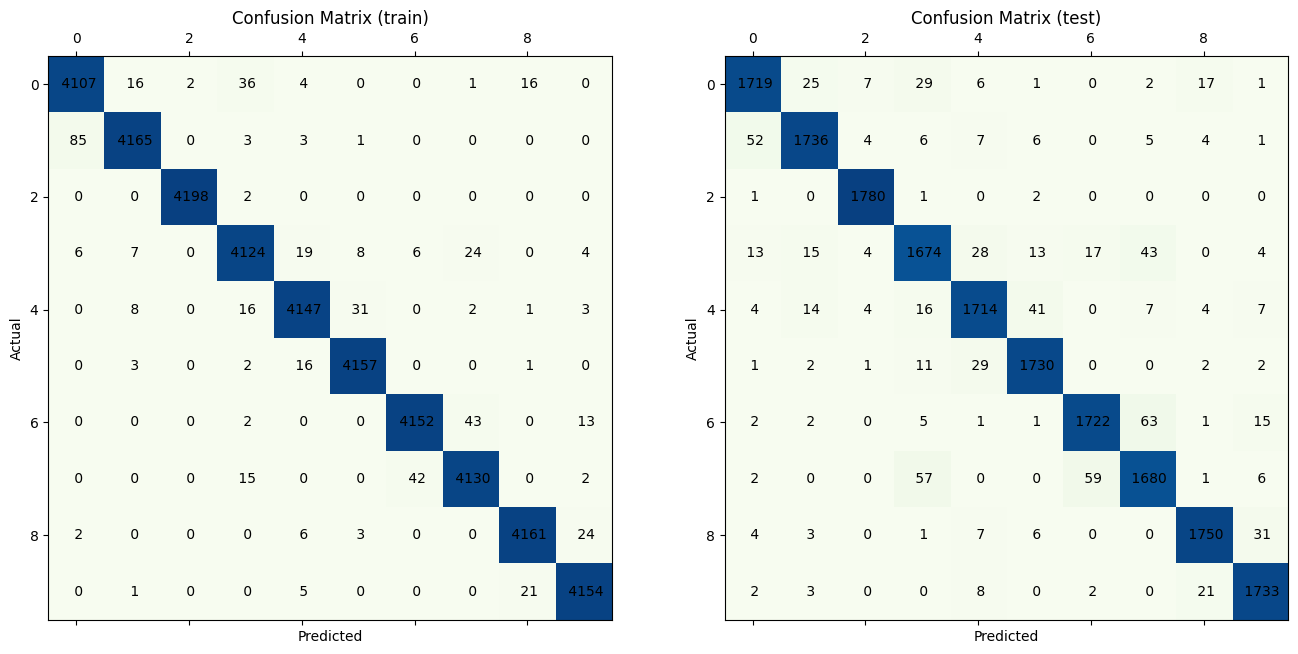

In [44]:
trees = random_forest(p4["X"], p4["Y"], n_trees=20, depth=15, impurity=gini, n_features=4)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

## Experiment on P5 data

### Number of trees: 10, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  96.56333333333333 %
Average F1 Score                :  0.9655947493523532
------------------ Test ----------------------
Classification Accuracy :  88.16666666666667 %
Average F1 Score                :  0.8813971040219541
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


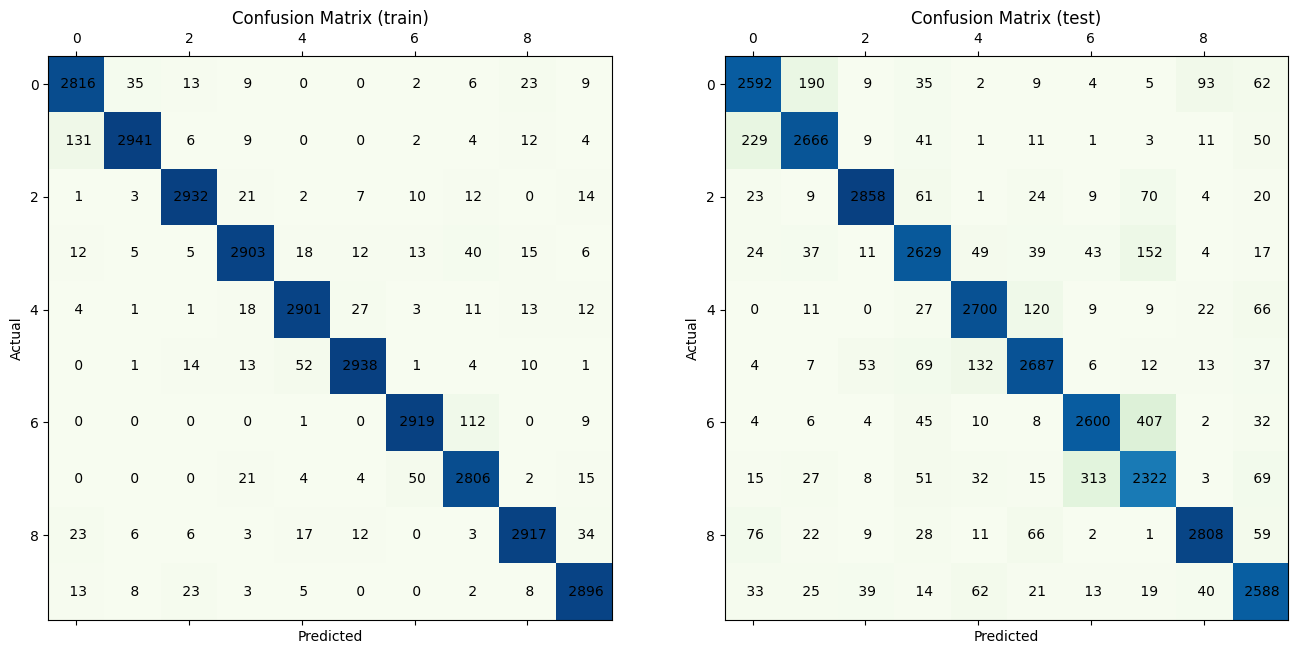

In [25]:
trees = random_forest(p5["X"], p5["Y"], n_trees=10, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 15, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  97.01333333333334 %
Average F1 Score                :  0.9700906002955716
------------------ Test ----------------------
Classification Accuracy :  91.88666666666667 %
Average F1 Score                :  0.9186691891128854
Confusion Matrix:
[[2743  163    6   14    3    1    2    7   48   13]
 [ 153 2763    3   21    7    2    2   10   21   18]
 [   4    5 2929    5    1   33    0    5    4   14]
 [  29   56   25 2775    9   35   19   34   14    4]
 [   1    0    0   44 2795  113    1    9    5   32]
 [   5    9   34   33  101 2735    3   12   67    1]
 [   4    2   11   31    2    5 2735  202    1    7]
 [   3    1   40  132   10    2  337 2471    1    3]
 [  67    4    2    1   12    5    2    2 2885   20]
 [  17   13    4    8   91   16   28   56   32 2735]]


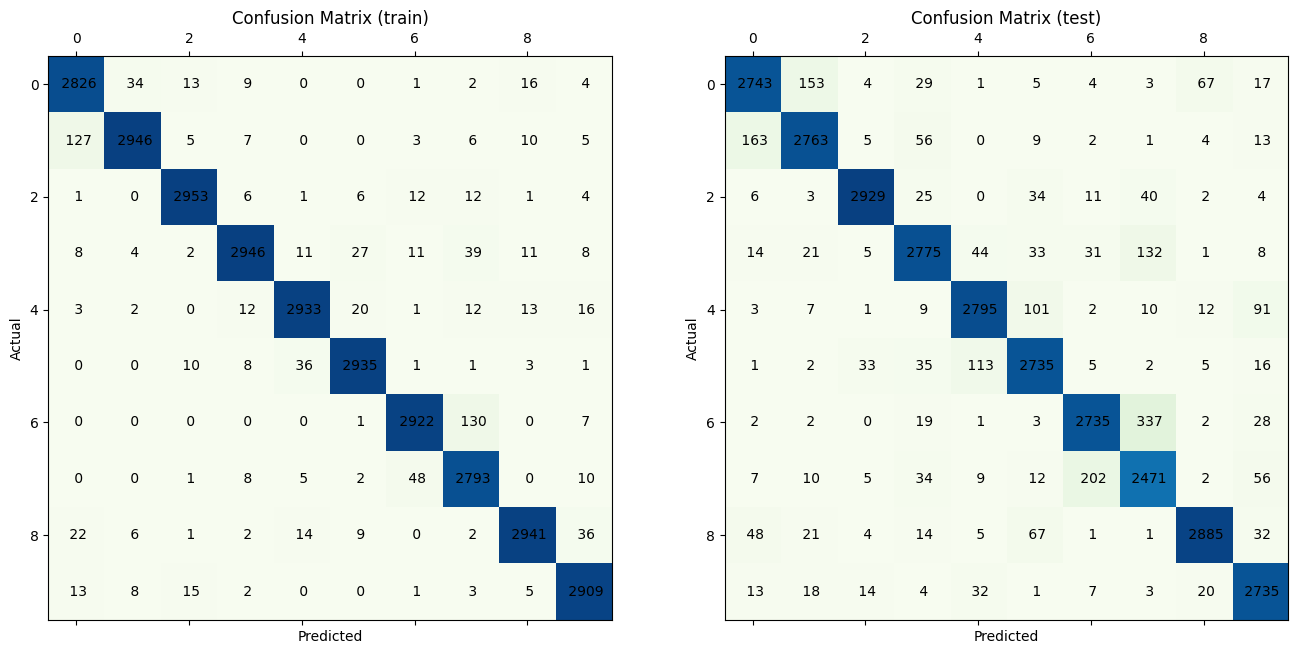

In [50]:
trees = random_forest(p5["X"], p5["Y"], n_trees=15, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  97.0 %
Average F1 Score                :  0.9699672712965761
------------------ Test ----------------------
Classification Accuracy :  91.89666666666668 %
Average F1 Score                :  0.9187780395705616
Confusion Matrix:
[[2734  170    5   14    3    2    1    3   57   11]
 [ 152 2755    1   22   12    2    2    7   29   18]
 [   4    6 2933    4    1   36    2    4    1    9]
 [  29   44   31 2763   12   34   23   39   19    6]
 [   1    0    0   44 2793  114    1    8    5   34]
 [   2    8   30   36  106 2739    3   12   63    1]
 [   4    1   10   29    3    3 2757  186    4    3]
 [   1    2   37  125    8    2  352 2471    1    1]
 [  70    9    3    1   10    4    1    1 2879   22]
 [  12   15    3   12   74   24   33   52   30 2745]]


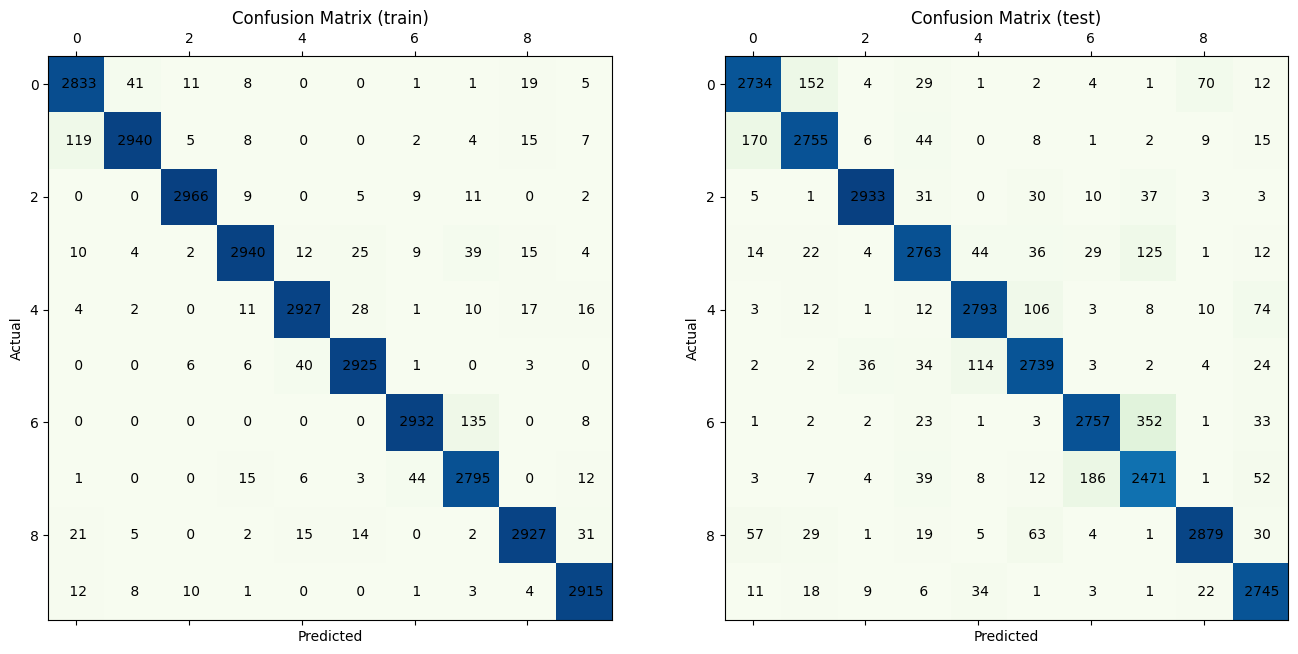

In [51]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 25, Number of features: 10

------------------ Train ---------------------
Classification Accuracy :  96.56333333333333 %
Average F1 Score                :  0.9655947493523532
------------------ Test ----------------------
Classification Accuracy :  88.16666666666667 %
Average F1 Score                :  0.8813971040219541
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


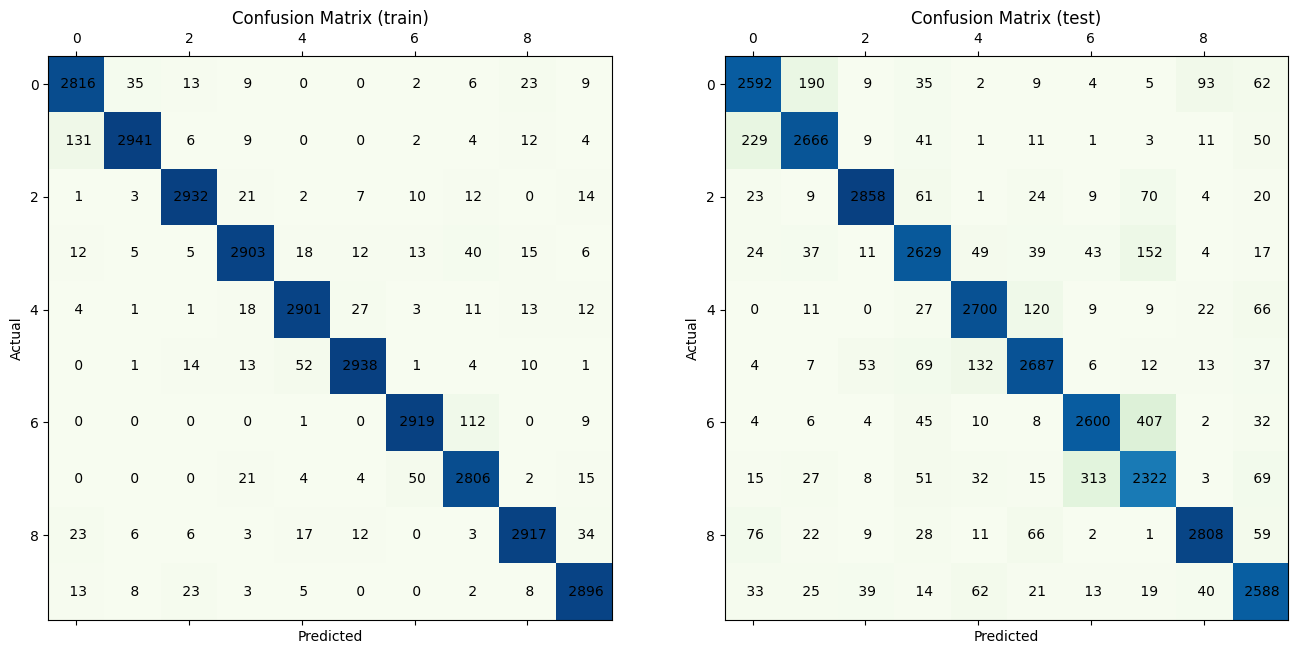

In [26]:
trees = random_forest(p5["X"], p5["Y"], n_trees=25, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 7

------------------ Train ---------------------
Classification Accuracy :  96.56333333333333 %
Average F1 Score                :  0.9655947493523532
------------------ Test ----------------------
Classification Accuracy :  88.16666666666667 %
Average F1 Score                :  0.8813971040219541
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


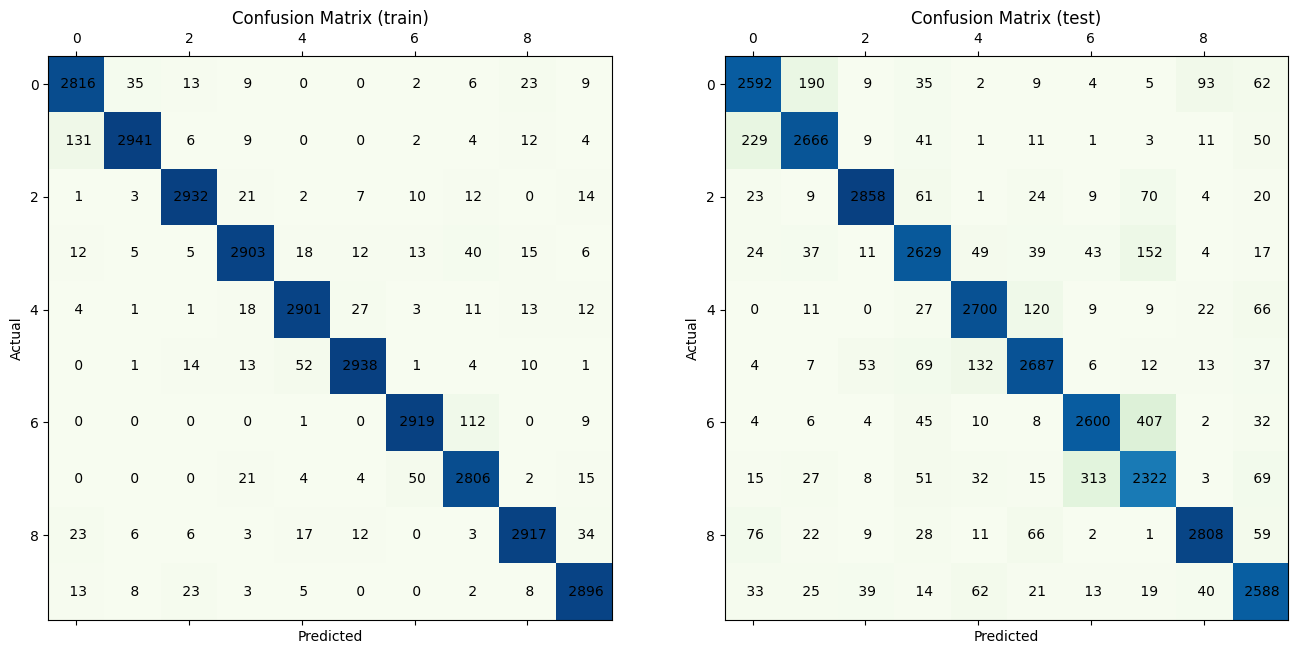

In [22]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini, n_features=7)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 5

------------------ Train ---------------------
Classification Accuracy :  97.02333333333333 %
Average F1 Score                :  0.970199648864144
------------------ Test ----------------------
Classification Accuracy :  90.81333333333333 %
Average F1 Score                :  0.9079323388141128
Confusion Matrix:
[[2705  178    9   16    6    2    1   10   56   17]
 [ 182 2712    1   25   11    2    6    9   24   28]
 [   6    3 2925    9    1   35    1    4    5   11]
 [  36   25   42 2741   12   37   26   49   28    4]
 [   2    1    4   54 2788   97    3    7   15   29]
 [   8   16   44   33  113 2685    8    6   80    7]
 [   3    0    3   36    4    5 2718  211    3   17]
 [   3    0   65  126    9    2  328 2462    2    3]
 [  99   12    6    2    5    9    2    1 2829   35]
 [  46   13   23   14   64   20   30   69   42 2679]]


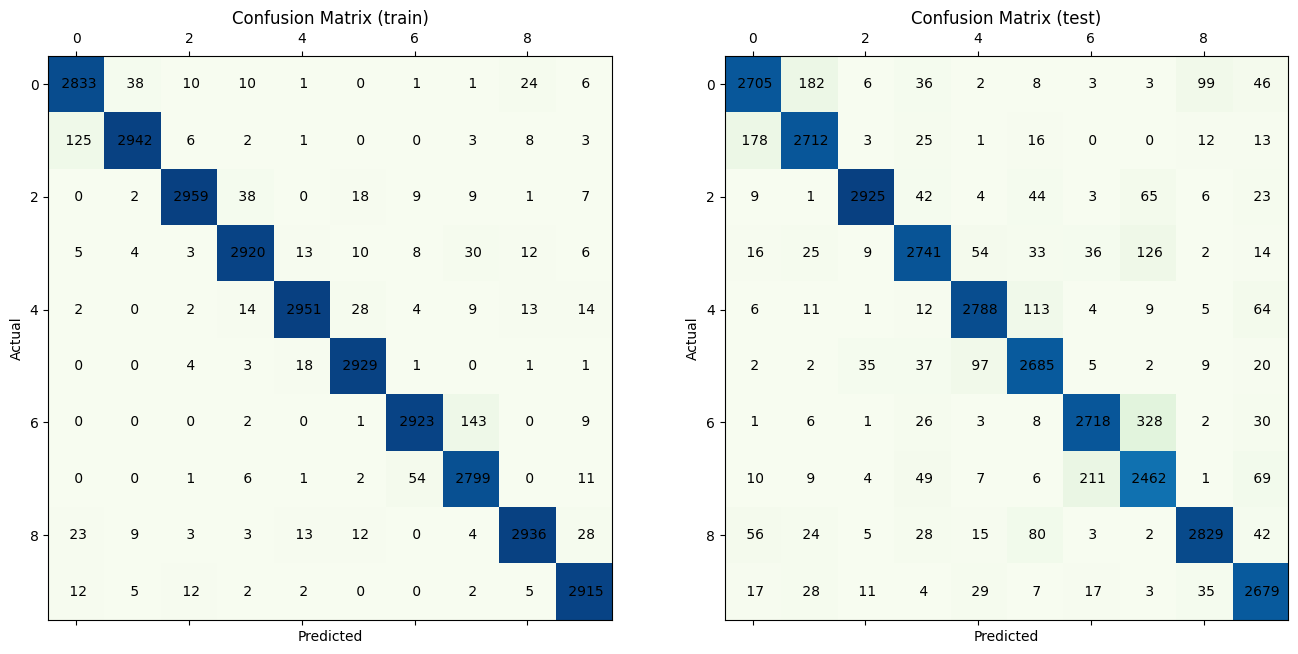

In [23]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini, n_features=5)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 3

------------------ Train ---------------------
Classification Accuracy :  97.73333333333333 %
Average F1 Score                :  0.977312623936089
------------------ Test ----------------------
Classification Accuracy :  91.84666666666666 %
Average F1 Score                :  0.9183972981918738
Confusion Matrix:
[[2731  172    5   16    0    1    1   10   52   12]
 [ 157 2743    1   34   12    1    3   11   14   24]
 [   6    3 2944    8    0   23    0    2    2   12]
 [  32   37   19 2763   11   41   24   42   21   10]
 [   1    0    1   47 2796  102    3    7    7   36]
 [   5   12   37   37   95 2753    2    2   52    5]
 [   8    1    4   29    1    2 2721  222    4    8]
 [   3    2   28  108    5    2  313 2532    1    6]
 [  90    9    0    4    9    9    1    2 2856   20]
 [  40   19   10   14   68   18   28   58   30 2715]]


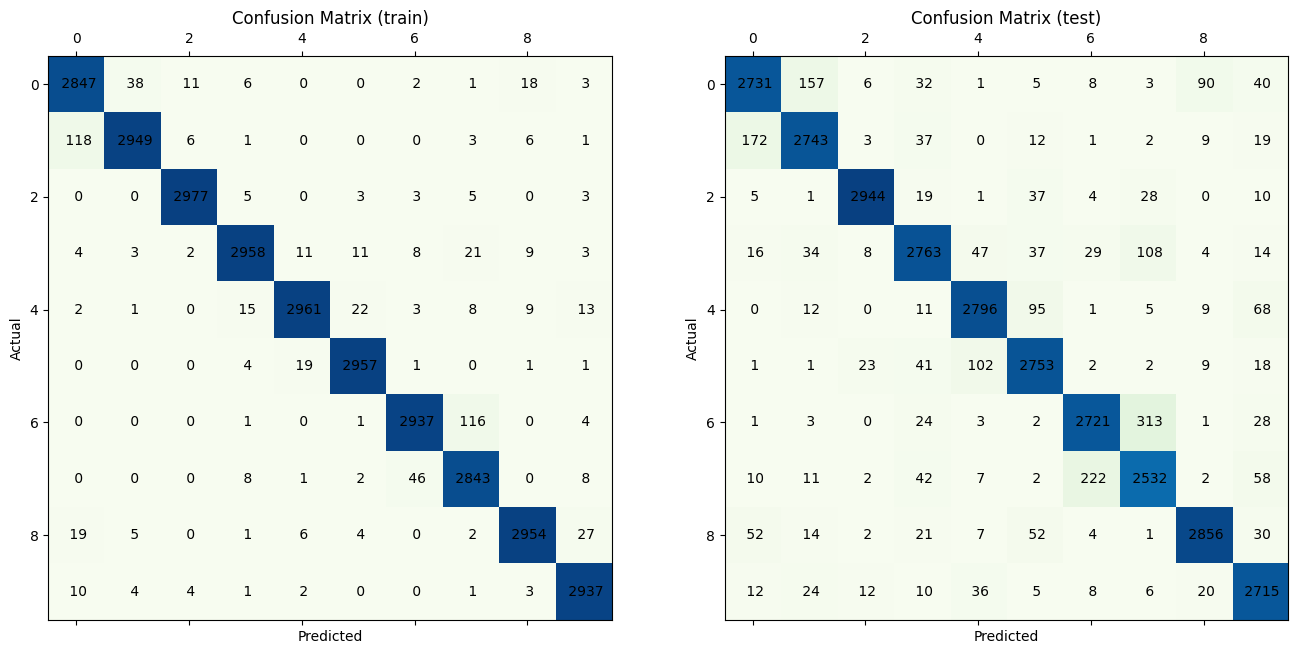

In [24]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini, n_features=3)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

# Problem 3

Implement the Adaboost algorithm with at least 3 learners and one of them must be a Neural Network (MLP/CNN). 

Report the comparison between this and using only one classifier. 

Plot the convergence of train error as a function of the number of learners.

Data: `p3, p4, p5`

In [39]:
# adaboost with numpy
def adaboost(X, Y, T, depth, stump):
    m, n = X.shape
    w = np.ones(m) / m
    trees = []
    alphas = []
    for _ in range(T):
        tree = stump(X, Y, w, depth)
        trees.append(tree)
        pred = predictAll(X, tree)
        err = np.sum(w * (pred != Y))
        alpha = 0.5 * np.log((1 - err) / (err + 2))
        alphas.append(alpha)
        w = w * np.exp(-alpha * Y * pred)
        w = w / np.sum(w)
    return trees, alphas

def predictAdaBoost(X, trees, alphas):
    return np.sign(np.sum([alpha * predictAll(X, tree) for alpha, tree in zip(alphas, trees)], axis=0))

# trees, alphas = adaboost(p3["X"], p3["Y"], 100, 1, lambda X, Y, w, depth: buildTree(X, Y, gini, depth))
# metrics.print(predictAdaBoost(p3["X"], trees, alphas), p3["Y"], predictAdaBoost(p3["X_test"], trees, alphas), p3["Y_test"], visualize=True, result=True)

# Problem 4

Consider the KMNIST data and implement 

    (a) GMM-based clustering, 
    
    (b) K means clustering.
    
Evaluate and compare the Normalized Mutual Information for both algorithms. 

Experiment with different number of cluster sizes and plot the t-sne plots for all cases.

Data: `p4`

## Implementation

### GMM based clustering

In [40]:
max_float = np.finfo("float64").max
max_exp = np.log(max_float)

def normal(x, mean ,cov):
    n = len(mean)
    val = -0.5 * (x - mean) @ np.linalg.pinv(cov) @ (x - mean)
    return np.exp(val) if np.abs(val) < max_exp else (1/max_float) / ((2 * np.pi * np.linalg.det(cov)) ** (n/2) + 1e-8)

# X -> data, k -> number of normal densities
def gmm(X, k, max_iter = 100, random_seed=42):
    # m -> number of datapoints, n -> number of features
    m, n = X.shape
    # initialization
    np.random.seed(random_seed)
    weights = np.random.dirichlet(np.ones(k))
    means = [np.mean(X) + np.random.rand(n) for _ in range(k)]
    covs = [np.diag(np.random.rand(n) * 2 + 0.5) for _ in range(k)]
    
    for i in range(max_iter):
        # if np.sum(weights) == 0:
        #     weights = np.ones(k) / k
            
        # Expectation step
        probs = np.array([[normal(x, means[i], covs[i]) * weights[i] for i in range(k)] for x in X])
        probs = (probs.T / np.sum(probs, axis=1)).T
        
        # Maximization step
        old_means = means.copy()
        covs = [(X - means[i]).T @ np.diag(probs.T[i]) @ (X - means[i]) / (np.sum(probs.T[i]) + 1e-8) for i in range(k)]
        means = [X.T @ probs.T[i] / (np.sum(probs.T[i]) + 1e-8)  for i in range(k)]
        weights = np.sum(probs, axis=0) / m
        
        if np.linalg.norm(np.array(means) - np.array(old_means)) < 1e-8:
            break
        
    return weights, means, covs

### K-means clustering

In [41]:
# k-means clustering using numpy
def kmeans(X, k, max_iter=100):
    # initialize centroids
    centroids = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(k, X.shape[1]))
    for _ in range(max_iter):
        # calculate distance of each point from each centroid
        distances = np.linalg.norm(X[:, None] - centroids, axis=-1)
        # assign each point to the closest centroid
        clusters = np.argmin(distances, axis=-1)
        # update centroids
        centroids = np.array([np.mean(X[clusters == i], axis=0) for i in range(k)])
    return clusters, centroids

In [42]:
# mutual information score between two variables
def mutualInfo(x, y):
    # joint distribution
    joint = np.histogram2d(x, y, bins=10)[0]
    # marginal distribution
    marginal_x = np.histogram(x, bins=10)[0]
    marginal_y = np.histogram(y, bins=10)[0]
    # calculate mutual information
    mi = 0
    for i in range(joint.shape[0]):
        for j in range(joint.shape[1]):
            if joint[i, j] != 0:
                mi += joint[i, j] * np.log(joint[i, j] / (marginal_x[i] * marginal_y[j]))
    return mi

def normalized_mutual_info_score(y_true, y_pred):
    return mutualInfo(y_true, y_pred) / np.sqrt(mutualInfo(y_true, y_true) * mutualInfo(y_pred, y_pred))

## Experiment

# Problem 5

Implement Principal Component Analysis on KMNIST. 

Plot the data variance as a function of the number of principal components.

Data: `p3, p4, p5`

## Implementation

In [10]:
# returns eigen vectors and eigen values sorted by eigen values
def pca(X):
    m = X.shape[0]
    X = X - np.mean(X, axis=0)
    cov = np.dot(X.T, X) / (m - 1)
    eigVals, eigVecs = np.linalg.eig(cov)
    idx = eigVals.argsort()[::-1]
    eigVecs = eigVecs[:, idx]
    eigVals = eigVals[idx]
    # return np.dot(X, eigVecs[:, :k])
    return eigVecs, eigVals

def pcaTransform(X, eigVecs, k):
    return np.dot(X, eigVecs[:, :k])

## Data variance vs number of principal components

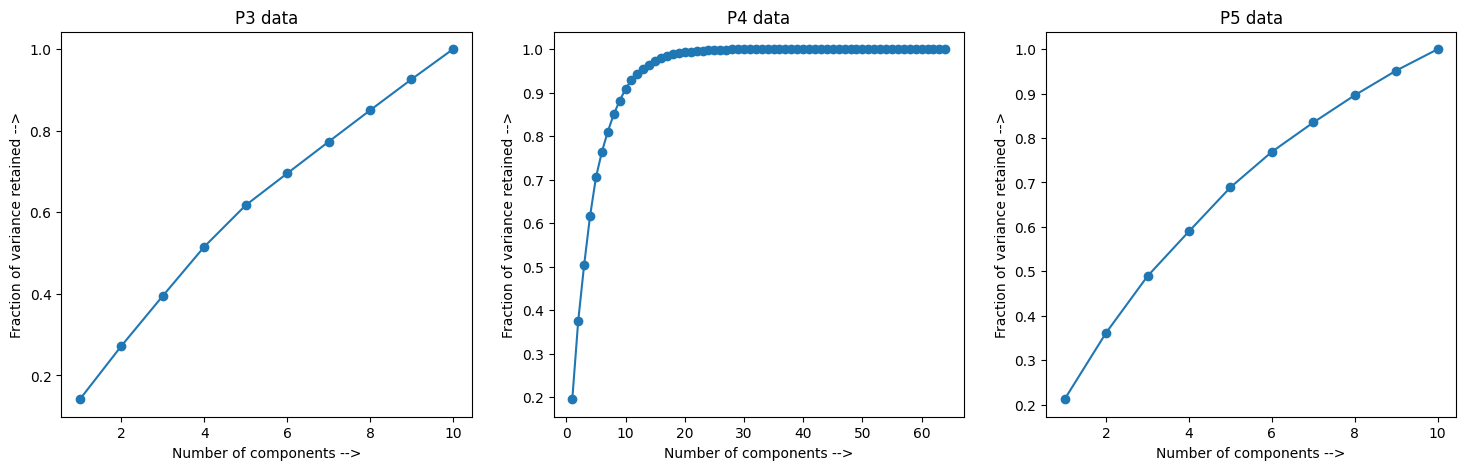

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
_, eigVals = pca(p3["X"])
eigValCumsum = np.cumsum(eigVals)
eigValCumsum = eigValCumsum / eigValCumsum[-1]
ax[0].plot(np.arange(1, len(eigVals) + 1), eigValCumsum, marker='o')
ax[0].set_xlabel("Number of components -->")
ax[0].set_ylabel("Fraction of variance retained -->")
ax[0].set_title("P3 data")

_, eigVals = pca(p4["X"])
eigValCumsum = np.cumsum(eigVals)
eigValCumsum = eigValCumsum / eigValCumsum[-1]
ax[1].plot(np.arange(1, len(eigVals) + 1), eigValCumsum, marker='o')
ax[1].set_xlabel("Number of components -->")
ax[1].set_ylabel("Fraction of variance retained -->")
ax[1].set_title("P4 data")

_, eigVals = pca(p5["X"])
eigValCumsum = np.cumsum(eigVals)
eigValCumsum = eigValCumsum / eigValCumsum[-1]
ax[2].plot(np.arange(1, len(eigVals) + 1), eigValCumsum, marker='o')
ax[2].set_xlabel("Number of components -->")
ax[2].set_ylabel("Fraction of variance retained -->")
ax[2].set_title("P5 data")

plt.show()
